<a href="https://colab.research.google.com/github/syma-afsha/AI_LAB/blob/main/new1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final Exam for Deep Network Development course**
Name:

Neptun ID:

Date: 17/06/2024

Duration: 9AM-11AM

## General rules
This notebook contains the task to be solved in order to pass the exam and complete the course.
It contains a task similar to what you have worked on during the semester, which consists on implementing a network architecture and a function. There are additional requirements which are optional.

The exam has a duration of 2 hours. You are free to distribute the time as you please between the different requirements.
During the exam you can use any resource (internet, AI, practice notebooks, etc). **However it is strictly prohibited to use any communication channel** (Teams, WhatsApp, Messenger, etc.). Using any of those will result in immediate **FAIL**.

Your solution should be submitted to Canvas as a .ipynb file!

Please note that, to **PASS** the exam you must **SUBMIT A SUCCESSFUL SOLUTION SATISFYING THE MINIMUM REQUIREMENTS**. If you **FAIL** the exam, you have the right to retry it **ONE MORE TIME**. If you **FAIL AGAIN**, then unfortunately, you have failed the course.

If you **PASS** the exam, then the final grade is the weighted average of your asignment defenses (theory and code).

## Task description & Requirements
The task is to implement a custom architecture and its forward function.
The task is inspired on Image Generation conditioned by text. The architecture contains an image encoder, a text encoder, a feature combination part and an image decoder. The model receives an image and a text as inputs and generates an image as output. For the extra part, you are required to change the feature combination block by applying cross-attention.

## Requirements:
------------------------------------------------------------------------
**Minimum requirements - ENOUGH TO PASS THE EXAM**
1.   Implement the layers of the architecture shown in section 1. Fill out the unknown parts in order to complete the architecture.
2.   Implement the forward function of the architecture. Make sure that the input and output are correct.

**!!! To complete the requirements 1 and 2, your final output should match the expected output indicated on cell 1.2. !!!**

------------------------------------------------------------------------

**Extra requirements - for grade improvement and potentially access to AI Lab**
3.   Replace the feature combination part with cross attention architecture. Use the output embeddings of the encoder implemented on cell 1.1 and fuse the embedding by applying cross attention. --> **+1 in final grade**
4.   Modify the architecture previously implemented to accept the new fused embedding and extend the architecture with the details shown on cell 1.4. --> **Access to AI Lab**
------------------------------------------------------------------------

In [ ]:
#Necessary imports
import torch
import torch.nn as nn
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 1. Architecture

Please right click the image and "Open image in a new tab" to view it better with zoom. Or download it from here: https://drive.google.com/file/d/1PRukDvpqFerXF3CoxeqI2A2ocOcHENsL/view?usp=sharing
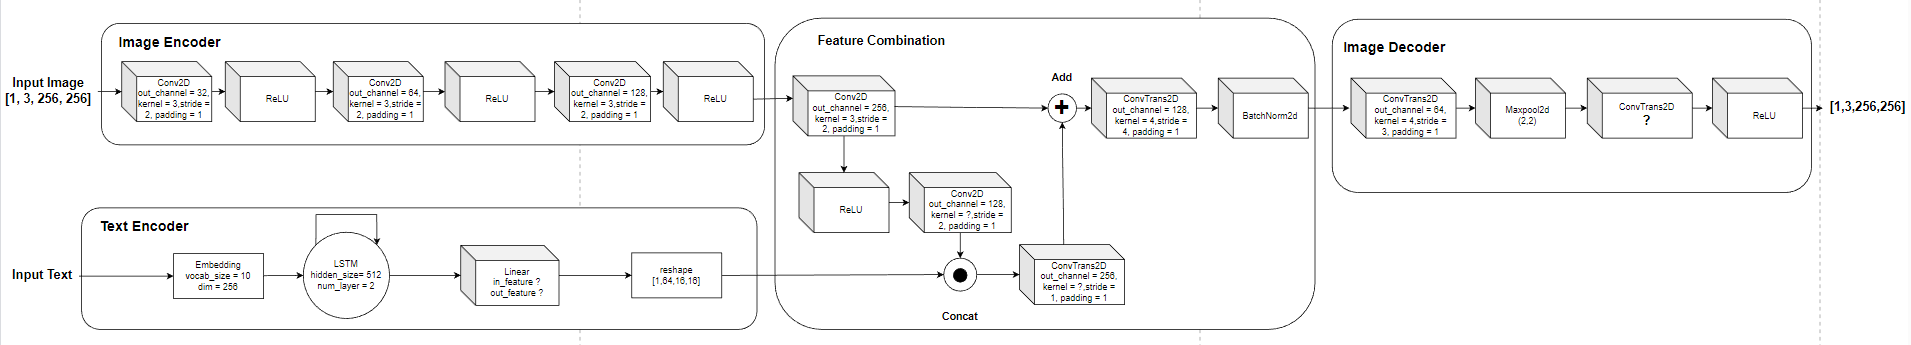

### 1.1. Implement the architecture and its forward function

In [ ]:
class ImageEncoder(nn.Module):
    def __init__(self):
        super(ImageEncoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.relu=nn.ReLU()




    def forward(self, input_image):
        print("Image input:", input_image.shape)
        x=self.conv1(input_image)
        x=self.relu(x)
        print("After conv1:", x.shape)
        x=self.conv2(x)
        x=self.relu(x)
        print("After conv2:", x.shape)
        x=self.conv3(x)
        x=self.relu(x)
        print("After conv3:", x.shape)


        return x
image_encoder=ImageEncoder()

sample_images = torch.randn(1, 3, 256, 256)
imag_enc=image_encoder(sample_images)


Image input: torch.Size([1, 3, 256, 256])
After conv1: torch.Size([1, 32, 128, 128])
After conv2: torch.Size([1, 64, 64, 64])
After conv3: torch.Size([1, 128, 32, 32])


In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, vocab_size, emdedding_dim):
        super(TextEncoder, self).__init__()
        self.embedding=nn.Embedding(num_embeddings=10,embedding_dim=256)
        self.lstm=nn.LSTM(input_size=256, hidden_size=512, num_layers=2)
        self.linear=nn.Linear(in_features=512*10, out_features=16384)


    def forward(self, input_tokens):
        print("Text input:", input_tokens.shape)
        x=self.embedding(input_tokens)
        print("After embedding:", x.shape)
        x, _ = self.lstm(x)
        print("After LSTM:", x.shape)
        x=x.view(1,-1)
        x=self.linear(x)
        print("After linear:", x.shape)
        x=x.unsqueeze(1).unsqueeze(2)
        x=x.view(1,64,16,16)
        print("After repeat:", x.shape)





        return x
vocab_size = 10
text_encoder=TextEncoder(10,256)
input_tokens = torch.randint(0, vocab_size, (1, 10))
text_enc=text_encoder(input_tokens)

Text input: torch.Size([1, 10])
After embedding: torch.Size([1, 10, 256])
After LSTM: torch.Size([1, 10, 512])
After linear: torch.Size([1, 16384])
After repeat: torch.Size([1, 64, 16, 16])


In [ ]:
class FeatureComb(nn.Module):
  def __init__(self):
        super(FeatureComb, self).__init__()
        self.conv1=nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1)
        self.conv2=nn.Conv2d(in_channels=256, out_channels=128, kernel_size=1, stride=2, padding=1)
        self.convtrans1=nn.ConvTranspose2d(in_channels=192, out_channels=256, kernel_size=10, stride=1, padding=1) #kernel
        self.relu=nn.ReLU()
        self.convtrans2=nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=4, padding=1)
        self.batchnorm=nn.BatchNorm2d(128)




  def forward(self, text_embeddings, image_embeddings):
        print("Text_embeddings:", text_embeddings.shape)

        print("Image_embeddings:", image_embeddings.shape)
        x1=self.conv1(image_embeddings)
        x=self.relu(x1)
        print("After conv1:", x1.shape)
        print("After relu:", x.shape)
        x=self.conv2(x)
        x=self.relu(x)
        print("After conv2:", x.shape)
        text_embeddings=text_embeddings[:,:,0:9,0:9]
        print("After crop:", x.shape)

        x=torch.cat((x,text_embeddings),dim=1)
        print("After concat:", x.shape)
        x=self.convtrans1(x)
        print("After convtrans1:", x.shape)
        x=x+x1
        print("After addition:", x.shape)
        x=self.convtrans2(x)
        print("After convtrans2:", x.shape)
        x=self.batchnorm(x)




        return x
feature_comb=FeatureComb()
feat=feature_comb(text_enc,imag_enc)

Text_embeddings: torch.Size([1, 64, 16, 16])
Image_embeddings: torch.Size([1, 128, 32, 32])
After conv1: torch.Size([1, 256, 16, 16])
After relu: torch.Size([1, 256, 16, 16])
After conv2: torch.Size([1, 128, 9, 9])
After crop: torch.Size([1, 128, 9, 9])
After concat: torch.Size([1, 192, 9, 9])
After convtrans1: torch.Size([1, 256, 16, 16])
After addition: torch.Size([1, 256, 16, 16])
After convtrans2: torch.Size([1, 128, 62, 62])


In [ ]:

class ImageDecoder(nn.Module):
    def __init__(self):
        super(ImageDecoder, self).__init__()
        self.convtrans1=nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=3, padding=1)
        self.pool=nn.MaxPool2d(kernel_size=2, stride=2)
        self.convtrans2=nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=3, stride=3, padding=10)
        self.relu=nn.ReLU()




    def forward(self, x):
        print("Decoder imgage",x.shape)
        x=self.convtrans1(x)
        x=self.pool(x)
        print("After convtrans1:", x.shape)
        print("After pool:", x.shape)
        x=self.convtrans2(x)
        x=self.relu(x)
        print("After convtrans2:", x.shape)

        return x
image_decoder=ImageDecoder()
img=image_decoder(feat)

Decoder imgage torch.Size([1, 128, 62, 62])
After convtrans1: torch.Size([1, 64, 92, 92])
After pool: torch.Size([1, 64, 92, 92])
After convtrans2: torch.Size([1, 3, 256, 256])


### 1.2 Check if your implementation is correct
For a given arbitraty image input of size (1,3,256,256) and text input of size (1,10), the expected output is (1,3,256,256)

In [ ]:
vocab_size = 10
embedding_dim = 256

text_encoder = TextEncoder(vocab_size, embedding_dim)
image_encoder = ImageEncoder()
feature_comb = FeatureComb()
image_decoder = ImageDecoder()

# Example data
input_tokens = torch.randint(0, vocab_size, (1, 10))
sample_images = torch.randn(1, 3, 256, 256)

text_embedding =text_encoder(input_tokens)
image_embedding = image_encoder(sample_images)
combined_features = feature_comb(text_embedding,image_embedding)
output = image_decoder(combined_features)

try:
    assert output.shape == torch.Size([1, 3, 256, 256])
    print("CONGRATULATIONS! You have PASSed the exam by successfully completing the minimum requirements!")
except AssertionError:
    print("Unfortunately, you have FAILed the exam by not being able to complete the minimum requirements.")

Text input: torch.Size([1, 10])
After embedding: torch.Size([1, 10, 256])
After LSTM: torch.Size([1, 10, 512])
After linear: torch.Size([1, 16384])
After repeat: torch.Size([1, 64, 16, 16])
Image input: torch.Size([1, 3, 256, 256])
After conv1: torch.Size([1, 32, 128, 128])
After conv2: torch.Size([1, 64, 64, 64])
After conv3: torch.Size([1, 128, 32, 32])
Text_embeddings: torch.Size([1, 64, 16, 16])
Image_embeddings: torch.Size([1, 128, 32, 32])
After conv1: torch.Size([1, 256, 16, 16])
After relu: torch.Size([1, 256, 16, 16])
After conv2: torch.Size([1, 128, 9, 9])
After crop: torch.Size([1, 128, 9, 9])
After concat: torch.Size([1, 192, 9, 9])
After convtrans1: torch.Size([1, 256, 16, 16])
After addition: torch.Size([1, 256, 16, 16])
After convtrans2: torch.Size([1, 128, 62, 62])
Decoder imgage torch.Size([1, 128, 62, 62])
After convtrans1: torch.Size([1, 64, 92, 92])
After pool: torch.Size([1, 64, 92, 92])
After convtrans2: torch.Size([1, 3, 256, 256])
CONGRATULATIONS! You have PASSe

# EXTRA REQUIREMENTS (OPTIONAL)

### 1.3. Fuse the embeddings
Replace the feature combination block with cross-attention. You are required to use the image embedding and text embedding to extact Q, K, V values.
Please right click the image and "Open image in a new tab" to view it better with zoom. Or download it from here: https://drive.google.com/file/d/1vPdrryaVCN_SL2kGMLKt5tRukkOdrWmj/view?usp=sharing
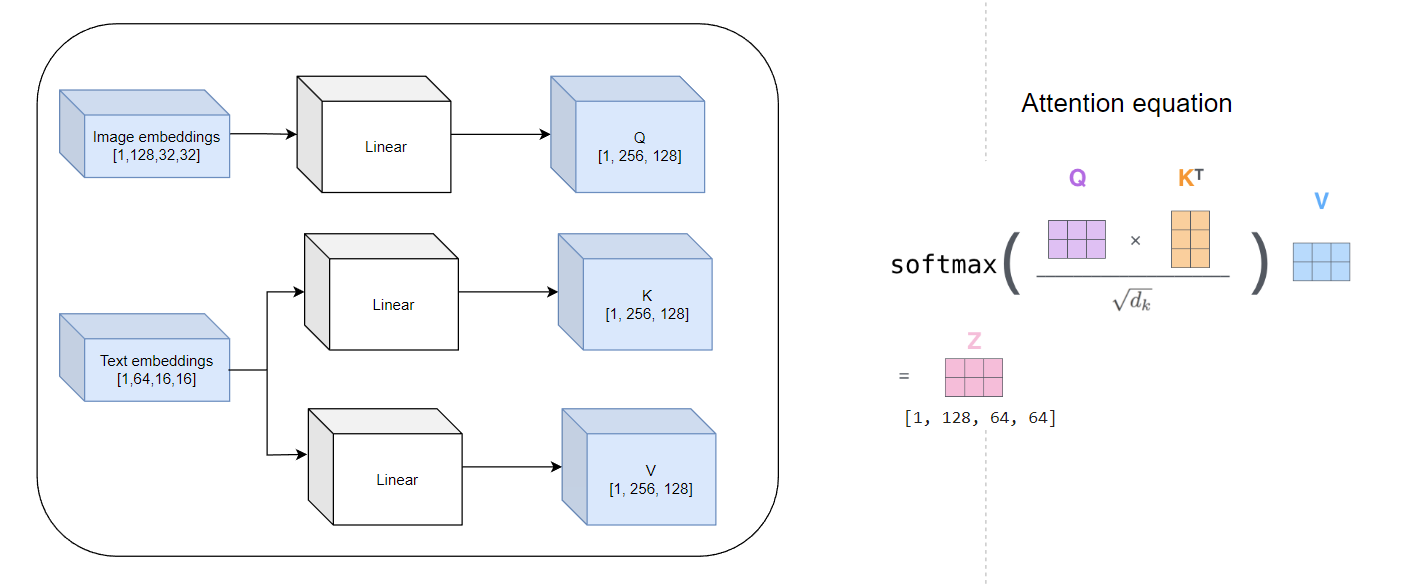

In [ ]:
class CrossAttention(nn.Module):
    def __init__(self, image_features_dim, text_features_dim, output_dim):
        super(CrossAttention, self).__init__()


    def forward(self, image_features, text_features):
        print("image_features:", image_features.shape)
        print("text_features:", text_features.shape)


        return image_features + attended_text_features

class FeatureComb_Modified(nn.Module):
  def __init__(self):
        super(FeatureComb_Modified, self).__init__()
        self.cross_attention = CrossAttention(image_features_dim=?, text_features_dim=?, output_dim=?)



  def forward(self,image_embeddings, text_embeddings):

        return x


In [ ]:
feature_comb_Modified = FeatureComb_Modified()
output = feature_comb_Modified(image_embedding,text_embedding)

try:
    assert output.shape == torch.Size([1,128, 64, 64])
    print("CONGRATULATIONS! You have earned +1 in your final grade by successfully satisfying one of the extra requirements!")
except AssertionError:
    print("Sorry! Keep trying!")

### 1.4. Modify and extend the architecture
Replace the text encoder with a transformer model:
- Use BertTokenizer
- maximize the sequence length to 16
- use Positional Encoding
- define the Transformer Encoder
- define a "connector" model to get the required shape(1, 64, 16, 16)
- replace the text encoder and try it out

In [ ]:
# New tester
embedding_dim = 256

text_encoder = TransformerEncoder()
connector = ConnectorModel(output_shape=(64, 16, 16))
image_encoder = ImageEncoder()
feature_comb = FeatureComb()
image_decoder = ImageDecoder()

# Example data
text = [
    "This is a sample text!"
]
sample_images = torch.randn(1, 3, 256, 256)  # Batch of images (assuming RGB images of size 256x256)
# Tokenize the text
input_ids = tokenize_text(text)
# Create the mask
attention_mask = torch.ones_like(input_ids, dtype=torch.bool)

text_encoder_output =text_encoder(input_ids, attention_mask)
text_embedding = connector(text_encoder_output)
print("Text embedding: ",text_embedding.shape)
image_embedding = image_encoder(sample_images)
print("Image embedding: ",image_embedding.shape)
combined_features = feature_comb(text_embedding,image_embedding)
output = image_decoder(combined_features)

In [ ]:
print("If you have completed this part, then CONGRATULATIONS! You will be suggested as a potential student to join the AI Lab!")

If you have completed this part, then CONGRATULATIONS! You will be suggested as a potential student to join the AI Lab!
